<a href="https://colab.research.google.com/github/AsmaaQ25/GenAI-CMP637-2025/blob/main/Notebooks/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### CMP637-GenAI Assignment-phase1 ## DR. Yahia
# Asmaa Qandeel Ali - 202211150
##### November 2025
 # Report and plot history here https://wandb.ai/asmaaqandeel2511-cairo-university/GenAI-Assignment-phase1/reports/MNIST-GenAI--VmlldzoxNTIzNTgxOQ?accessToken=3046w987dk9m7ddxr1ho4whrxp8bykyvh1kqu122a4qyozhxsc174qd21pcxnjde 

In [1]:
# Note: Don't import any other libraries for deep learning or ML in general.
import math
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms

# If you wish, you can include other libraries related to side tasks
# such as drawing images, showing a progress bar, etc.
import matplotlib.pyplot as plt
import tqdm.notebook as tqdm
import wandb

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

## Define utility functions

In [2]:
# Note: If you wish to add or modify some utility functions, feel free to do so.

# You can change this variable to choose between discrete and continuous images
# In the discrete case, the image channels are of type uint8 with values from 0 to 255
# In the continous case, the image channels are of type float with values from 0 to 1
use_discrete_data = False

# Show a batch of images x and their corresponding classes y
# Params:
# - x: A tensor of shape [Batch Size, 1, Height, Width] and type float
# - y: A tensor of shape [Batch Size] and type int64
def show_images(x: torch.Tensor, y: torch.Tensor):
  # Convert images to a color uint8 numpy array
  #first unflatten the tensor
  x = x.view(x.shape[0], 1, 28, 28)
  if use_discrete_data:
    x = x[:, 0].clamp(0,255).cpu().numpy()
    x = np.stack([x.astype(np.uint8)]*3, axis=-1)
  else:
    x = x[:, 0].clamp(0,1).cpu().numpy()
    x = np.stack([(x * 255).astype(np.uint8)]*3, axis=-1)
  # Calculate the number of rows and columns to organize the images
  count = x.shape[0]
  rows = max(1, int(count ** 0.5))
  columns = max(1, count // rows)
  # Draw a grid or images
  plt.figure(figsize=(columns, rows))
  for i in range(count):
    plt.subplot(rows, columns, i+1)
    plt.imshow(x[i])
    plt.axis('off')
    plt.title(f"Class: {y[i]}", fontsize=10)
  plt.subplots_adjust(wspace=0.3, hspace=0.7, left=0.1, right=0.9, top=0.9, bottom=0.1)
  plt.show()

 ## Load and visualize the dataset
 I added image Flattening

In [3]:
# TODO [Optional]: You can modify the transforms.
# Note: If you modify the transforms, you may need to modify the `show_images` function.
if use_discrete_data:
  transform = transforms.Compose([
      transforms.PILToTensor(),
      transforms.Lambda(lambda t: t.view(-1))            ## (1,28,28) => (784,)
  ])
else:
  transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Lambda(lambda t: t.view(-1))            ## (1,28,28) => (784,)
  ])

# This will load the dataset into the folder "datasets" the first time it is run
dataset = torchvision.datasets.MNIST(root="datasets", download=True, transform=transform)

100%|██████████| 9.91M/9.91M [00:00<00:00, 40.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.07MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.76MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.54MB/s]


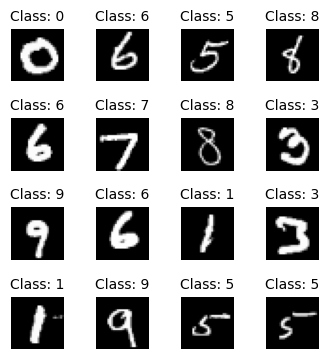

In [4]:
def show_dataset_sample(sample_size: int = 100):
  # sample_size must be a square number so the grid is all full
  loader = DataLoader(dataset, batch_size=sample_size, shuffle=True)
  x, y = next(iter(loader))
  x = x.view(sample_size, 1, 28, 28)
  y = y.view(sample_size)
  show_images(x, y)

show_dataset_sample(sample_size=16)

## Select a device

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Selected Device:", device)

Selected Device: cuda


## Define the model

In [6]:
# import torch
# import torch.nn as nn
# 


# from torch.nn.utils import clip_grad_norm_

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# # ----------------------------------------------------
# # Conditional Energy Network
# # ----------------------------------------------------
# class ConditionalEnergyNet(nn.Module):
#     """
#     E(x,y) where x ∈ [0,1], y ∈ {0..9} embedded.
#     Input shape: (B,1,28,28), labels: (B,)
#     Output: (B,) energy scalars
#     """
#     def __init__(self, embed_dim=32):
#         super().__init__()

#         # label embedding
#         self.embed = nn.Embedding(10, embed_dim)

#         # image encoder
#         self.conv1 = nn.Conv2d(1 + 1, 32, 3, stride=2, padding=1)   # condition channel added
#         self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
#         self.conv3 = nn.Conv2d(64, 128, 3, stride=1, padding=1)

#         self.fc = nn.Linear(128 * 7 * 7, 128)
#         self.head = nn.Linear(128, 1)

#     def forward(self, x, y):
#         """
#         x: (B,1,28,28)
#         y: (B,)
#         """
#         B = x.shape[0]

#         # convert label into conditioning channel
#         y_embed = self.embed(y)                        # (B, embed_dim)
#         y_channel = y_embed.unsqueeze(2).unsqueeze(3)  # (B, embed_dim,1,1)
#         y_channel = y_channel.expand(-1, -1, 28, 28)   # broadcast to (B, embed_dim, 28,28)

#         # reduce conditional channel to a single map
#         y_map = y_channel.mean(dim=1, keepdim=True)    # (B,1,28,28)

#         inp = torch.cat([x, y_map], dim=1)             # (B,2,28,28)

#         h = F.relu(self.conv1(inp))
#         h = F.relu(self.conv2(h))
#         h = F.relu(self.conv3(h))
#         h = h.view(B, -1)
#         h = F.relu(self.fc(h))
#         e = self.head(h).squeeze(1)
#         return e


# # ----------------------------------------------------
# # Conditional EBM with Langevin Sampling
# # ----------------------------------------------------
# class ConditionalEBM:
#     def __init__(
#             self,
#             lr=1e-4,
#             embed_dim=32,
#             langevin_steps=64,
#             step_size=10.0,        # η = 10
#             noise_std=0.001,       # low noise var
#             grad_clip=5.0
#     ):
#         self.langevin_steps = langevin_steps
#         self.step_size = step_size
#         self.noise_std = noise_std
#         self.grad_clip = grad_clip

#         self.net = ConditionalEnergyNet(embed_dim=embed_dim).to(device)
#         self.opt = torch.optim.Adam(self.net.parameters(), lr=lr)

#     # -----------------------------
#     # Compute energy
#     # -----------------------------
#     def energy(self, x, y):
#         return self.net(x, y)

#     # -----------------------------
#     # Langevin dynamics sampler
#     # -----------------------------
#     @torch.no_grad()
#     def sample(self, y, batch_size=None):
#         """
#         y: (B,)
#         Returns: samples conditioned on y, (B,1,28,28)
#         """
#         B = y.shape[0]
#         x = torch.rand(B, 1, 28, 28, device=device)

#         for i in range(self.langevin_steps):
#             x.requires_grad_(True)

#             e = self.energy(x, y).sum()
#             grad = torch.autograd.grad(e, x)[0]

#             # update step
#             x_new = x - self.step_size * grad

#             # add noise except for LAST step
#             if i < self.langevin_steps - 1:
#                 x_new += self.noise_std * torch.randn_like(x)

#             # always clamp
#             x = x_new.clamp(0.0, 1.0).detach()

#         return x

#     # -----------------------------
#     # One training step
#     # -----------------------------
#     def train_step(self, x_data, y_data):
#         self.net.train()

#         B = x_data.size(0)

#         # generate negative samples
#         x_neg = self.sample(y_data)

#         # compute energies
#         e_pos = self.energy(x_data, y_data)
#         e_neg = self.energy(x_neg, y_data)

#         # objective: E(data) - E(model samples)
#         loss = e_pos.mean() - e_neg.mean()

#         # optimize
#         self.opt.zero_grad()
#         loss.backward()

#         # GRADIENT CLIPPING (requested)
#         clip_grad_norm_(self.net.parameters(), self.grad_clip)

#         self.opt.step()

#         return loss.item()


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class EBM(nn.Module):
    def __init__(self, x_dim=784, y_dim=10, hidden=512):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(x_dim + y_dim, hidden),
            nn.GELU(),
            nn.Linear(hidden, hidden),
            nn.GELU(),
            nn.Linear(hidden, 1)
        )

    def forward(self, x, y):
        """
        x: (B, 784)
        y: (B, 10) one-hot
        returns: (B,) energies
        """
        xy = torch.cat([x, y], dim=1)
        E = self.net(xy)
        return E.squeeze(-1)

    def sample(self, y, steps=60, step_size=10.0, noise_std=0.01):
        """
        Unadjusted Langevin Sampling.
        y: one-hot labels (B, 10)
        returns: sampled images in [0,1]
        """

        B = y.size(0)
        device = y.device

        # start from random noise
        x = torch.rand(B, 784, device=device)

        for t in range(steps):
            # new tensor requiring grad
            x = x.detach().clone().requires_grad_(True)

            E = self.forward(x, y)
            grad_x = torch.autograd.grad(E.sum(), x)[0]

            # update
            x = x - step_size * grad_x

            # add noise except last step
            if t < steps - 1:
                x = x + noise_std * torch.randn_like(x)

            # clip to valid range
            x = x.clamp(0, 1)

        return x.detach()


# Instantiate model and optim
# Trainig

In [12]:
from torch.optim import Adam
from tqdm import tqdm

def train_ebm(model, train_loader, epochs=10, lr=1e-4, 
              steps=60, step_size=10.0, noise_std=0.01, grad_clip=1.0):

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)

    optim = Adam(model.parameters(), lr=lr)
    epoch_losses = []
    
    for epoch in range(epochs):
        # for x, y in train_loader:
        for x, y in tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}"):

            # flatten images
            x = x.view(x.size(0), -1).to(device)

            # convert labels to one-hot
            y_onehot = F.one_hot(y, num_classes=10).float().to(device)

            # true energy
            E_real = model(x, y_onehot).mean()

            # fake samples
            x_fake = model.sample(
                y_onehot,
                steps=steps,
                step_size=step_size,
                noise_std=noise_std
            )

            # fake energy
            E_fake = model(x_fake, y_onehot).mean()

            # loss
            loss = E_real - E_fake

            optim.zero_grad()
            loss.backward()

            # gradient clipping (important)
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

            optim.step()

        print(f"Epoch {epoch+1}/{epochs} | Loss: {loss.item():.4f}")
        epoch_losses.append(loss.item())
        wandb.log({"epoch": epoch , "loss": loss.item()})
    return epoch_losses

In [14]:

config = {
    "hidding_dim": 512,
    "batch_size": 64,
    "epochs": 10,
    "lr": 1e-4,
    "steps" : 60,
    "step_size" : 10.0,
    "noise_std" : 0.01,
    "grad_clip": 1.0,
    "optimizer": "adam",
    "model_architecture": "EnergyBased_Langevin Dynamics"}

train_loader = DataLoader(dataset, batch_size=config["batch_size"], shuffle=True)
model = EBM()

wandb.login(key="9bf31a65f3249f4d45183b47993a4fdc3328db1f")
wandb_logger = wandb.init(project="GenAI-Assignment-phase2", name="ebm_v1", config = config) 

loss_history = train_ebm(
    model = model,
    train_loader = train_loader,
    epochs = config["epochs"],
    lr = config["lr"],
    steps = config["steps"],
    step_size = config["step_size"],
    noise_std = config["noise_std"],
    grad_clip = config["grad_clip"]
)


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: asmaaqandeel2511 (asmaaqandeel2511-cairo-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch 0/10: 100%|██████████| 938/938 [01:02<00:00, 14.91it/s]


Epoch 1/10 | Loss: 0.0388


Epoch 1/10: 100%|██████████| 938/938 [01:02<00:00, 14.90it/s]


Epoch 2/10 | Loss: -0.0143


Epoch 2/10: 100%|██████████| 938/938 [01:03<00:00, 14.85it/s]


Epoch 3/10 | Loss: 0.0259


Epoch 3/10: 100%|██████████| 938/938 [01:03<00:00, 14.87it/s]


Epoch 4/10 | Loss: 0.0302


Epoch 4/10: 100%|██████████| 938/938 [01:03<00:00, 14.84it/s]


Epoch 5/10 | Loss: -0.0124


Epoch 5/10: 100%|██████████| 938/938 [01:02<00:00, 14.93it/s]


Epoch 6/10 | Loss: 0.0173


Epoch 6/10: 100%|██████████| 938/938 [01:02<00:00, 14.95it/s]


Epoch 7/10 | Loss: 0.0131


Epoch 7/10: 100%|██████████| 938/938 [01:03<00:00, 14.75it/s]


Epoch 8/10 | Loss: -0.0333


Epoch 8/10: 100%|██████████| 938/938 [01:03<00:00, 14.88it/s]


Epoch 9/10 | Loss: 0.0328


Epoch 9/10: 100%|██████████| 938/938 [01:02<00:00, 14.95it/s]

Epoch 10/10 | Loss: -0.0218


# Plot the loss function
for more detailed report visit my wandb report here to show all the loss and training experiments.

Well, not all, but the last working ones :-D 

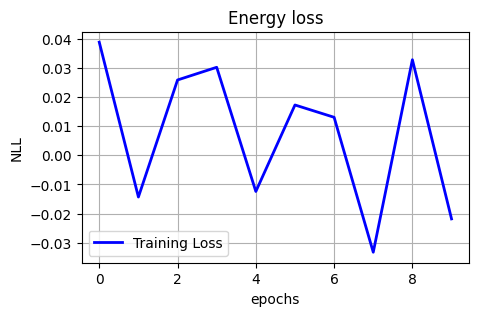

In [16]:
plt.figure(figsize=(5, 3))
plt.plot(loss_history, label='Training Loss', color='blue', linewidth=2)

plt.title('Energy loss')
plt.xlabel('epochs')
plt.ylabel('NLL')
plt.legend()
plt.grid(True)
plt.show()

## [Optional] Save and/or load the model

In [ ]:
# ## Optional TODO: Save the model if you want to store your work on disk and load it later
# torch.save(model.state_dict(), "made_temp.pth")

# loaded_model = ContinuousConditionalMADE(
#     input_size=input_dim,
#     cond_size=10,
#     hidden_sizes=hidden_dim,
# )
# # loaded_model = ConditionalMADE(input_size=input_dim,
# #                         cond_size=10,
# #                         hidden_sizes=hidden_dim,
# #                         natural_ordering=True)
# loaded_model.load_state_dict(torch.load("made_temp.pth"))

## Generate some images and display them

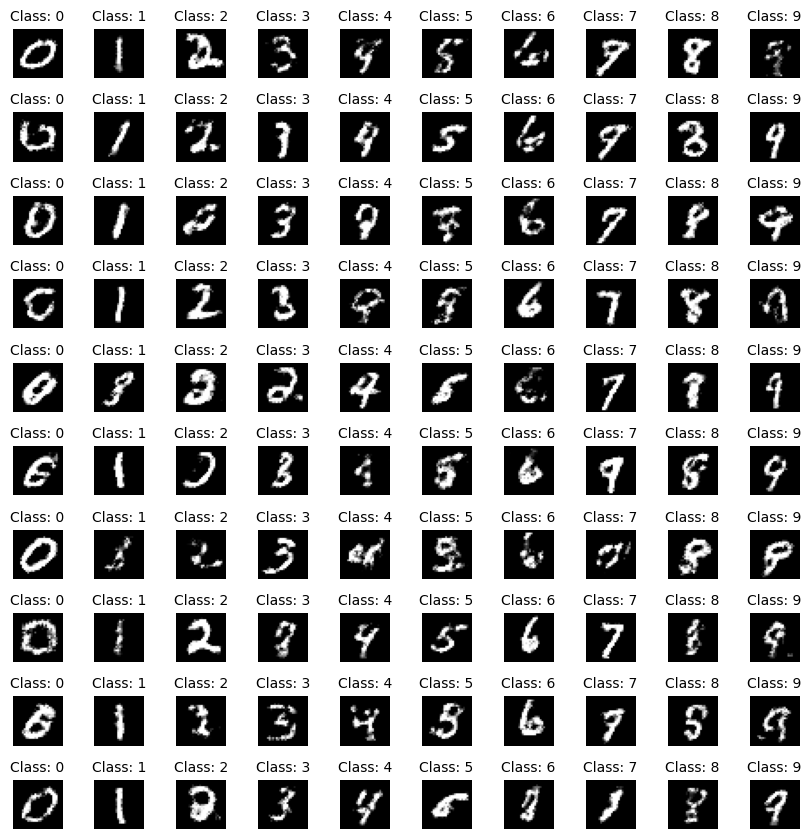

In [17]:
def generate(y: torch.Tensor) -> torch.Tensor:
    y_cond =  nn.functional.one_hot(y, num_classes=10).float().to(device)
    model.eval() # put model in evaluation mode
    new_x = model.sample(y_cond)
    return new_x
    
# Generate 100 images (10 images per class x 10 classes)
y = torch.tensor([i for _ in range(10) for i in range(10)], dtype=torch.long)

x = generate(y)
show_images(x, y)

In [18]:
# log images in wandb
x = x.view(x.shape[0], 1, 28, 28) # un-flatten the images
if use_discrete_data:
    x = x[:, 0].clamp(0,255).cpu().numpy()
    x = np.stack([x.astype(np.uint8)]*3, axis=-1)
else:
    x = x[:, 0].clamp(0,1).cpu().numpy()
    x = np.stack([(x * 255).astype(np.uint8)]*3, axis=-1)
    
batch_size = x.shape[0]

# Draw a grid or images
wandb_image_list = []
sample_table = wandb.Table(columns=["images", "labels"])
for i in range(batch_size):
    caption_text = f"Label: {y[i].item()}"
    wandb_image = wandb.Image(x[i], caption=caption_text)
    wandb_image_list.append(wandb_image)
    
# 4. Log the entire list in a single wandb.log() call
wandb.log({"Generated Samples Grid": wandb_image_list})
wandb_logger.finish()

# visualize generation of one sample

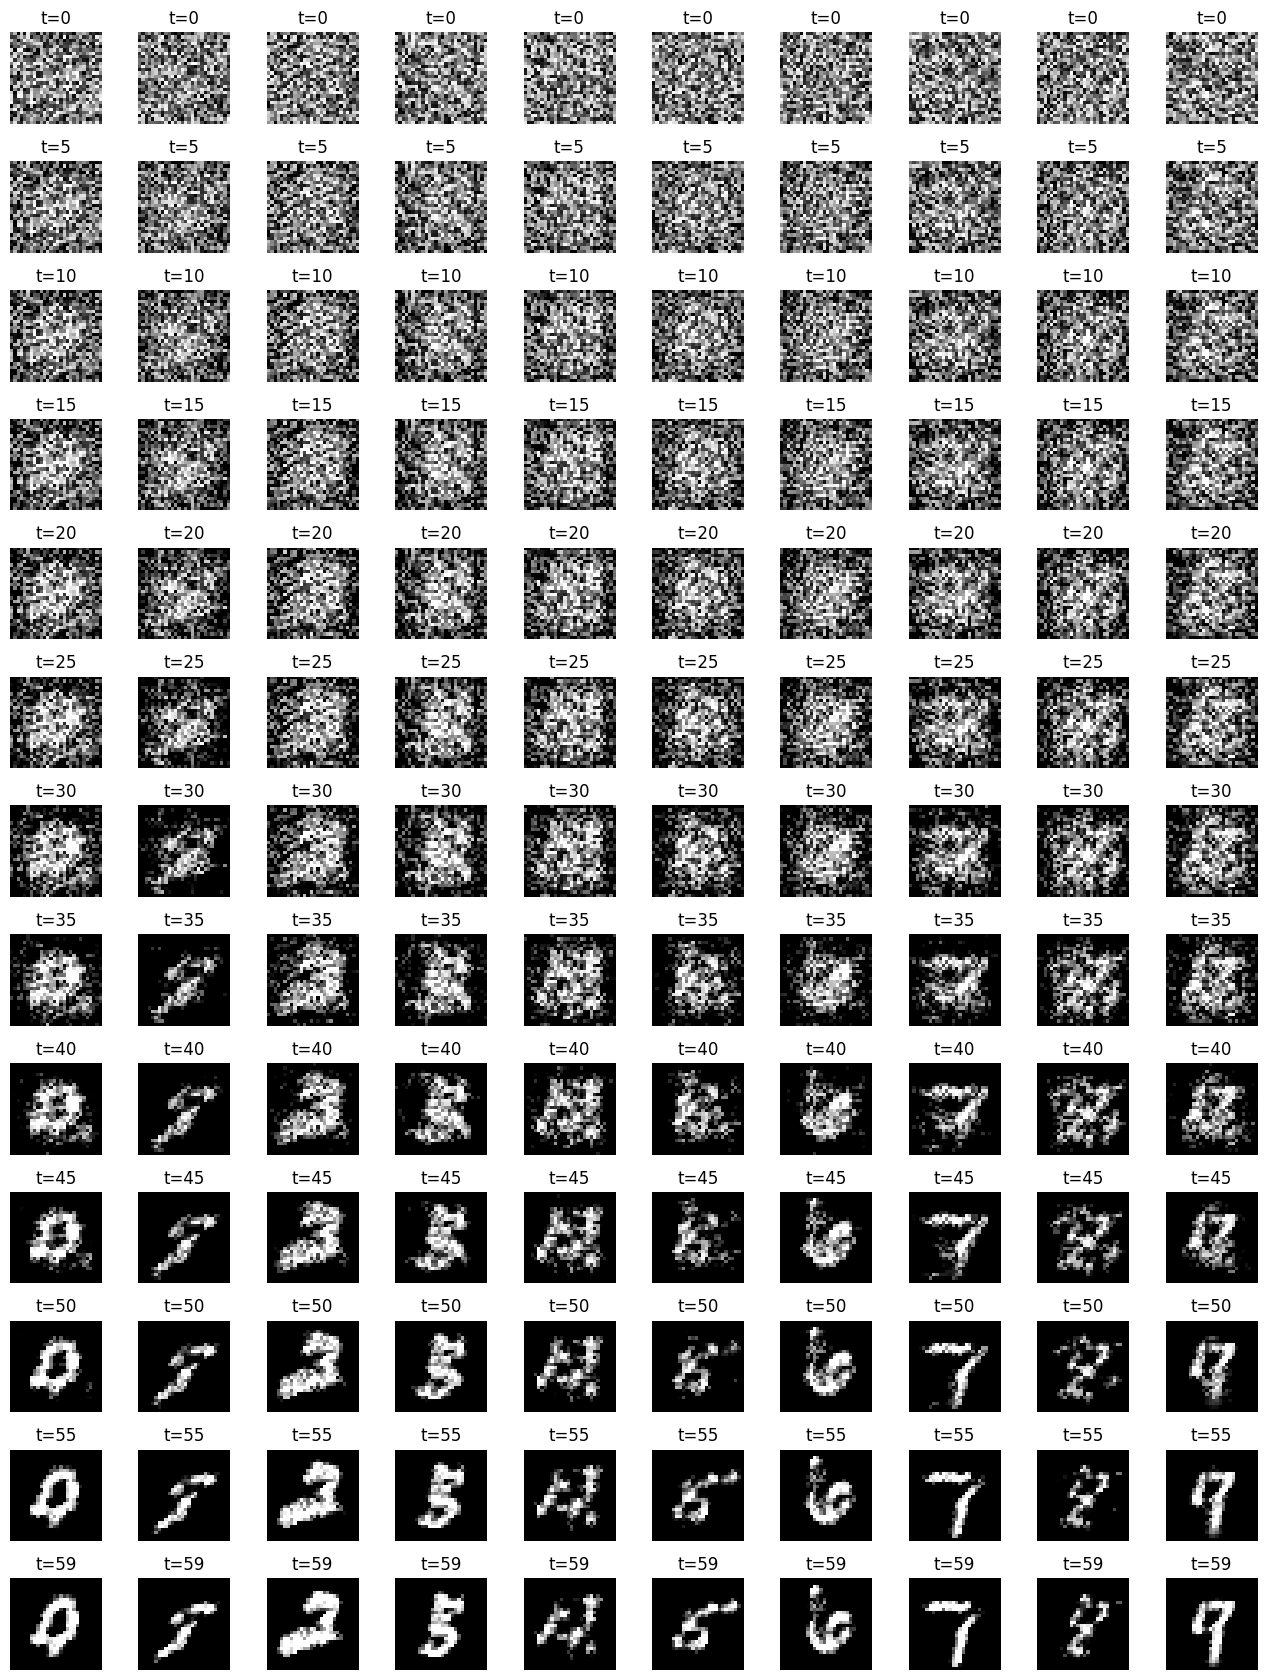

In [22]:
import matplotlib.pyplot as plt
import math
import torch

def visualize_sampling(model, y_onehot, steps=60, step_size=10.0, noise_std=0.01, 
                       n_show=8, interval=5):
    """
    Visualizes the sampling trajectory from random noise.
    
    model: trained EBM
    y_onehot: one-hot labels (B,10)
    n_show: number of samples to visualize
    interval: save image every 'interval' steps
    """

    device = next(model.parameters()).device

    # pick first n_show labels
    y = y_onehot[:n_show].to(device)

    shape = (1, 28, 28)
    x = torch.rand(n_show, 784, device=device)
    frames = []

    for t in range(steps):
        # requires grad
        x = x.detach().clone().requires_grad_(True)

        # forward
        E = model(x, y)
        grad_x = torch.autograd.grad(E.sum(), x)[0]
        x = x - step_size * grad_x
        if t < steps - 1:
            x = x + noise_std * torch.randn_like(x)
        x = x.clamp(0, 1)

        x_img = x.view(n_show, *shape).detach().cpu()

        # save frame every interval steps
        if t % interval == 0 or t == steps - 1:
            frames.append((t, x_img))

    # plot all saved frames
    rows = len(frames)
    cols = n_show

    plt.figure(figsize=(cols * 1.3, rows * 1.3))

    plot_i = 1
    for (t, imgs) in frames:
        for i in range(n_show):
            plt.subplot(rows, cols, plot_i)
            if imgs.shape[1] == 1:
                plt.imshow(imgs[i, 0], cmap='gray')
            else:
                plt.imshow(imgs[i].permute(1, 2, 0))
            plt.title(f"t={t}")
            plt.axis("off")
            plot_i += 1

    plt.tight_layout()
    plt.show()

# generate 8 samples of digit class '3'

# y = torch.tensor([3]*8) # see same number many times
y = torch.tensor([i  for i in range(10)], dtype=torch.long)

y_onehot = F.one_hot(y, num_classes=10).float()

visualize_sampling(model, y_onehot,
                   steps=60,
                   step_size=10.0,
                   noise_std=0.01,
                   n_show=10,
                   interval=5)


## [Optional] Extras

You can do any extra stuff you want here. Some examples are:
* Draw a graph of the loss functions.
* Implement interpolation in latent space (You can try it with Normalizing flows, Latent variable models and Implicit models).
* Implement image in-painting (You can try it with Score-based models, and in a limited form with Autoregressive models too).
* Visualize the generation process (You can try it with Energy-based and Score-based models).